In [1]:
# Parameters 
import yfinance as yf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

ticker_1 = input("Enter Ticker 1: ")
ticker_2 = input("Enter Ticker 2: ")
PeriodBacktest = "1y"

# Inverse Switch 
Inverse = 1  # Set this to 1 for inverse strategy
#Default is Zero yo

def download_data(tickers, period=PeriodBacktest):
    data = yf.download(tickers, period=period)
    #time.sleep(5)
    return data['Adj Close']  # Getting the adjusted close prices


#Set which tickers we want 
tickers = [ticker_1.upper(), ticker_2.upper()]
dataset = download_data(tickers) #Downloads dataset

#Section to rename Dataframe such that there is a Upper and lower asset
# Get the last row of the dataset
last_row = dataset.iloc[-1]

# Determine which column has the higher value and which has the lower
if last_row[tickers[0]] > last_row[tickers[1]]:
    upper_asset = tickers[0]
    lower_asset = tickers[1]
else:
    upper_asset = tickers[1]
    lower_asset = tickers[0]

# Create a dictionary for renaming columns
rename_dict = {
    upper_asset: "Upper_Asset",
    lower_asset: "Lower_Asset"
}

# Rename the columns
dataset.rename(columns=rename_dict, inplace=True)

# Optionally, print the dataset to verify
print(dataset.head())

Enter Ticker 1: SPY
Enter Ticker 2: QQQ
[*********************100%%**********************]  2 of 2 completed
            Lower_Asset  Upper_Asset
Date                                
2022-11-03   258.736176   365.260040
2022-11-04   262.897980   370.517242
2022-11-07   265.788422   374.061432
2022-11-08   267.725281   376.079681
2022-11-09   261.547150   368.331635


In [2]:
# Check if the required columns exist in the dataframe
if 'Lower_Asset' in dataset.columns and 'Upper_Asset' in dataset.columns:
    # Creating a new column 'Spread' which is the difference between 'Lower_Asset' and 'Upper_Asset'
    dataset['Spread'] = dataset['Upper_Asset'] - dataset['Lower_Asset']
else:
    print("Columns Lower_Asset and/or Upper_Asset do not exist in the dataframe.")
        
# Find StdDev 
std_Spread = dataset['Spread'].std()
print(f"STD.DEV= {std_Spread}")

# Find Mean
spread_mean = dataset['Spread'].mean()
print(f"Mean= {spread_mean}")

# Checking for NaN values before calculating the correlation
if dataset['Lower_Asset'].notna().all() and dataset['Upper_Asset'].notna().all():
    # Calculating the correlation between 'Lower_Asset' and 'Upper_Asset' columns
    correlation_lower_upper = dataset['Lower_Asset'].corr(dataset['Upper_Asset'])
    print(f"Correlation= {correlation_lower_upper}")
else:
    print("There are NaN values in the 'Lower_Asset' and/or 'Upper_Asset'. Correlation calculation skipped.")


STD.DEV= 16.498364010683265
Mean= 86.9299553765191
Correlation= 0.9712382240630418


In [3]:
#Set thresholds based on statistical significance, such as a z-score of 1.5 or -1.5 as trigger points.
#Set Vars
Z_ScoreTrigger = 1.0

Z_ScoreExit = 0 #exits when asset at this Z-score

dataset['Spread_ZScore'] = (dataset['Spread'] - spread_mean) / std_Spread


# Create signals for trading (1 for long the spread, -1 for short the spread, 0 for no position)
long_entries = (dataset['Spread_ZScore'] <= -Z_ScoreTrigger).astype(int)
short_entries = (dataset['Spread_ZScore'] >= Z_ScoreTrigger).astype(int)
exits = ((dataset['Spread_ZScore'] >= -Z_ScoreExit) & (dataset['Spread_ZScore'] <= Z_ScoreExit)).astype(int)

# Combine the signals to define the positions based on the value of 'Inverse'
if Inverse == 1:
    positions = long_entries - short_entries
else:
    positions = short_entries - long_entries
positions[exits == 1] = 0
positions_df = positions.to_frame(name='positions')

# Output the positions as a trading signal
# In a live trading scenario, you'd connect this logic to your brokerage's API to execute trades.
#print(positions)

# When Positions = 1, Long the spread, Long Upper_Asset, Short Lower_Asset 
if isinstance(positions, pd.Series):
    dataset['positions'] = positions  # Add positions as a column to the dataset DataFrame if it's a Series

# Now, create the 'Lower_Asset' and 'Upper_Asset' columns based on the 'positions' column
# Create 'Lower_Asset.Status' and 'Upper_Asset.Status' columns based on the conditions provided.
# Apply the logic to create 'Lower_Asset.Status' and 'Upper_Asset.Status' columns in 'positions_df' DataFrame
positions_df['Lower_Asset.Status'] = positions_df['positions'].apply(lambda x: 'SHORT' if x == 1 else ('LONG' if x == -1 else '-'))
positions_df['Upper_Asset.Status'] = positions_df['positions'].apply(lambda x: 'LONG' if x == 1 else ('SHORT' if x == -1 else '-'))
# Output positions_df for review
print(positions_df.head())



            positions Lower_Asset.Status Upper_Asset.Status
Date                                                       
2022-11-03         -1               LONG              SHORT
2022-11-04         -1               LONG              SHORT
2022-11-07         -1               LONG              SHORT
2022-11-08         -1               LONG              SHORT
2022-11-09         -1               LONG              SHORT


In [4]:
#Combine dfs, 
combined_df = pd.merge(dataset, positions_df, on='Date', how='inner')
# Drop the 'Spread' and 'Spread_ZScore' columns
combined_df = combined_df.drop(['Spread', 'Spread_ZScore','positions_x','positions_y'], axis=1)

# Sort the dataframe by date just in case it's not sorted
combined_df.sort_values('Date', inplace=True)

# Shift the 'Lower_Asset' column up to get the next day's price in the current row
combined_df['Next_Day_Lower_Asset'] = combined_df['Lower_Asset'].shift(-1)

# Calculate the change in price
combined_df['Price_Change_Lower_Asset'] = combined_df['Next_Day_Lower_Asset'] - combined_df['Lower_Asset']

# Define a function to calculate P&L based on status
def calculate_pnl(row):
    if row['Lower_Asset.Status'] == 'LONG':
        # If 'Long', P&L is the price change
        return row['Price_Change_Lower_Asset']
    elif row['Lower_Asset.Status'] == 'SHORT':
        # If 'Short', P&L is also the price change but may be calculated differently
        return -row['Price_Change_Lower_Asset']
    else:
        # If not 'Long' or 'Short', no position is taken, hence P&L is 0
        return 0

# Apply the function to calculate P&L
combined_df['P&L'] = combined_df.apply(calculate_pnl, axis=1)

# Now you can drop the 'Next_Day_Lower_Asset' and 'Price_Change_Lower_Asset' columns if they are not needed
combined_df.drop(columns=['Next_Day_Lower_Asset', 'Price_Change_Lower_Asset'], inplace=True)

# Return the updated DataFrame
#combined_df


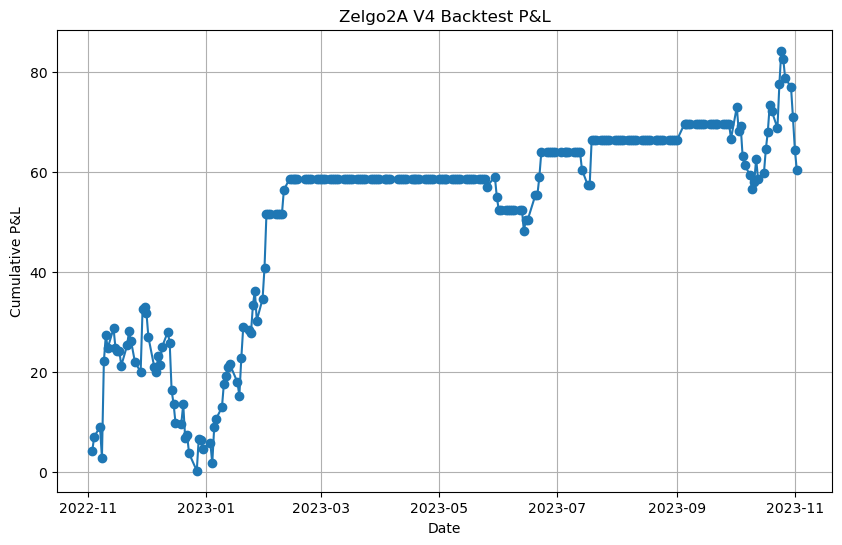

Total P&L: 60.39
Maximum Drawdown: -38.91%
Sharpe Ratio: 1.27
Z Score Trigger: 1.0
Inverse Switch: 1
Assets: ['SPY', 'QQQ']


In [9]:
#Prepares the Datecolumn from Index
combined_df['Date']=combined_df.index

# Calculate the cumulative P&L
combined_df['Cumulative P&L'] = combined_df['P&L'].cumsum()

# Plot the cumulative P&L
plt.figure(figsize=(10, 6))
plt.plot(combined_df['Date'], combined_df['Cumulative P&L'], marker='o')
plt.title('Zelgo2A V4 Backtest P&L')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.grid(True)
plt.show()
# Calculate the total P&L
total_pnl = combined_df['P&L'].sum()
total_pnl= round(total_pnl,2)


# Calculate the Maximum Drawdown
rolling_max = combined_df['Cumulative P&L'].cummax()  # The peak value until the current point
daily_drawdown = combined_df['Cumulative P&L'] - rolling_max  # The drawdown at each point in time
max_drawdown = daily_drawdown.min()  # The maximum drawdown
max_drawdown_percent = (max_drawdown / rolling_max.max()) * 100
max_drawdown_percent= round(max_drawdown_percent,2)


# Calculate the Sharpe Ratio
# Assuming risk-free rate is a constant, if you have a risk-free rate, subtract it from the returns
sharpe_ratio = combined_df['P&L'].mean() / combined_df['P&L'].std() * np.sqrt(252)  # Annualized Sharpe Ratio
sharpe_ratio= round(sharpe_ratio,2)



#Clean up DF
combined_df.drop(columns=['Date'], inplace=True)

#Print
print(f"Total P&L: {total_pnl}")
print(f"Maximum Drawdown: {max_drawdown_percent}%")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Z Score Trigger: {Z_ScoreTrigger}")
print(f"Inverse Switch: {Inverse}")
print(f"Assets: {tickers}")